# Stochastic alpha, beta, rho (SABR) model 

The SABR model describes the dynamics of the forward price $F$ of an asset under a stochastic volatility process. The forward price $F(t)$ and its volatility $\sigma (t)$ evolve according to the following stochastic differential equations (SDEs):

$$
\begin{cases}
dF_t = \sigma_t F_t^\beta dW_t \\
d\sigma_t = \alpha \sigma_t dZ_t \\
dW_t dZ_t = \rho dt
\end{cases}
$$

Here, $W_t$ and $Z_t$ are two correlated Wiener processes with correlation coefficient $\rho$. The parameters are:
- $\sigma_0$ (initial volatility)
- $\beta \in [0,1]$ (elasticity parameter)
- $\rho \in (-1,1)$ (correlation between the asset and its volatility)
- $\alpha \geq 0$ (volatility of volatility)

The SABR model reduces to the CEV (constant elasticity of variance) model if $\alpha=0$. 

## Imports

In [220]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt

In [221]:
N = norm.cdf

## SABR Model Implied Volatility Calculation

The SABR implied volatility formula used in the `sabr_vol` function is derived from Hagan's original lognormal vol expansion (Hagan et al., 2002).

#### SABR Formula:

$$
V(\sigma_0, \beta, \rho, \alpha, F, K, T) = 
\begin{cases} 
    V_z & \text{if } F \neq K \\
    V_0 & \text{if } F = K
\end{cases}
$$

Where:
- $V_z$ and $V_0$ are the implied volatilities for non-zero and zero $z$ values, respectively.
- $\varepsilon$ is a small positive value (numerical stability threshold).
- $z$ is a parameter calculated based on the input parameters.

### Formula for $V_z$:

$$
V_z = \frac{{\sigma_0 \cdot z \cdot (1 + (a + b + c) \cdot T)}}{{d \cdot (1 + v + w) \cdot D(\rho, z)}}
$$

### Formula for $V_0$:

$$
V_0 = \frac{{\sigma_0 \cdot (1 + (a + b + c) \cdot T)}}{{d \cdot (1 + v + w)}}
$$

### Sub-formulas:

#### Formula for $a$:
$$
a = \frac{{(1 - \beta)^2 \cdot \sigma_0^2}}{{24 \cdot (FK)^{1-\beta}}}
$$

#### Formula for $b$:
$$
b = \frac{{0.25 \cdot \rho \cdot \beta \cdot \alpha \cdot \sigma_0}}{{\sqrt{(FK)}}}
$$

#### Formula for $c$:
$$
c = \frac{{(2 - 3 \rho^2) \cdot \alpha^2}}{{24}}
$$

#### Formula for $d$:
$$
d = \sqrt{(FK)}
$$

#### Formula for $v$:
$$
v = \frac{{(1 - \beta)^2 \cdot \ln{(F/K)}^2}}{{24}}
$$

#### Formula for $w$:
$$
w = \frac{{(1 - \beta)^4 \cdot \ln{(F/K)}^4}}{{1920}}
$$

#### Formula for $z$:
$$
z = \frac{{\alpha \cdot \sqrt{(FK)} \cdot \ln{(F/K)}}}{{\sigma_0}}
$$


### Auxiliary Function $x$:

The function $D(\rho, z)$ calculates the $D$ parameter used in the SABR formula.

$$
D(\rho, z) = \ln\left(\frac{\sqrt{1 - 2 \rho z + z^2} + z - \rho}{1 - \rho}\right)
$$


In [253]:
def sabr_vol(sigma_0, beta, rho, alpha, F, K, T):
    """Calculate SABR model implied volatility.

    Parameters:
    sigma_0 : float : Initial volatility
    beta : float : Elasticity parameter
    rho : float : Correlation between asset price and volatility
    alpha : float : Volatility of volatility
    F : float : Forward price
    K : float : Strike price
    T : float : Time to maturity

    Returns:
    float : Implied volatility
    """
    logfk = np.log(F / K)
    fkbeta = (F*K)**(1 - beta)
    a = (1 - beta)**2 * sigma_0**2 / (24 * fkbeta)
    b = 0.25 * rho * beta * alpha * sigma_0 / np.sqrt(fkbeta)
    c = (2 - 3*rho**2) * alpha**2 / 24
    d = np.sqrt(fkbeta)
    v = (1 - beta)**2 * logfk**2 / 24
    w = (1 - beta)**4 * logfk**4 / 1920

    if F == K:
        return sigma_0 * (1 + (a + b + c) * T) / (d * (1 + v + w))
    else:
        z = alpha * np.sqrt(fkbeta) * logfk / sigma_0
        return sigma_0 * z * (1 + (a + b + c) * T) / (d * (1 + v + w) * D(rho, z))

def D(rho, z):
    a = np.sqrt(1 - 2*rho*z + z**2) + z - rho
    b = 1 - rho
    return np.log(a / b)

Now lets test this model with some example parameters.

In [254]:
sigma_0=0.2
beta=0.5
rho=-0.3
alpha=0.4
F=100
K=105
T=1
r=0.01

In [255]:
implied_vol = sabr_vol(sigma_0, beta, rho, alpha, F, K, T)
print(f"SABR Implied Volatility: {implied_vol:.4f}")

SABR Implied Volatility: 0.0202


### Calibration

The calibration step of the SABR model involves finding the parameters $\sigma_0, \rho, \alpha$ that minimize the MSE for the models implied volatilities to the observed market implied volatilities. 
Let's denote:
- $\sigma_{\text{market}, i}$ as the market implied volatility for strike $K_i$,
- $\sigma_{\text{SABR}}(K_i, \beta; \sigma_0, \rho, \alpha)$ as the model-implied volatility given strike $K_i$ and SABR parameters $\sigma_0, \beta, \rho, \alpha$.

The objective function to minimize is:

$$
\text{MSE}(\sigma_0, \rho, \beta, \alpha) = \frac{1}{n} \sum_{i=1}^{n} \left(\sigma_{\text{market}, i} - \sigma_{\text{SABR}}(K_i, \beta; \sigma_0, \rho, \alpha)\right)^2
$$

Where $n$ is the number of market data points.

In [256]:
def objective_function(params, market_vols, strikes, F, T, beta):
    sigma_0, rho, alpha = params
    model_vols = [sabr_vol(sigma_0, beta, rho, alpha, F, K, T) for K in strikes]
    return np.sum((np.array(model_vols) - np.array(market_vols))**2)

We test this optimization using some synthetic data. 

In [257]:
market_strikes = np.array([90, 95, 100, 105, 110])
market_vols = np.array([0.25, 0.22, 0.20, 0.22, 0.25])
initial_guess = [sigma_0, rho, alpha]

In [258]:
result = minimize(
    objective_function, 
    initial_guess, 
    args=(market_vols, market_strikes, F, T, beta), 
    method='L-BFGS-B',
    bounds=[(0.01, 2), (-0.99, 0.99), (0.01, 2)],
    options={'ftol': 1e-7}
)
sigma_0_calibrated, rho_calibrated, alpha_calibrated = result.x
beta_calibrated = beta
print(f"Calibrated Parameters: sigma_0={sigma_0_calibrated:.4f}, beta={beta_calibrated:.4f}, rho={rho_calibrated:.4f}, alpha={alpha_calibrated:.4f}")

Calibrated Parameters: sigma_0=1.5436, beta=0.5000, rho=0.0754, alpha=2.0000


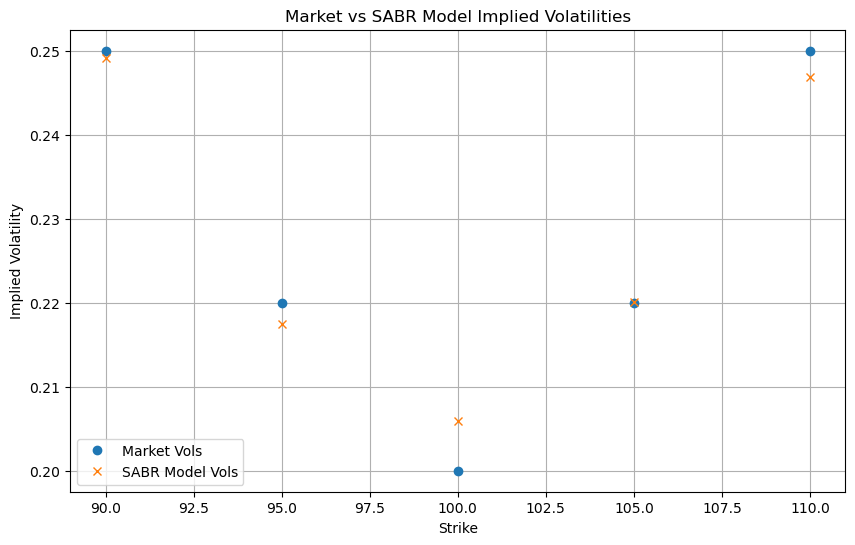

In [259]:
model_vols = [sabr_vol(sigma_0_calibrated, beta_calibrated, rho_calibrated, alpha_calibrated, F, K, T) for K in market_strikes]

plt.figure(figsize=(10, 6))
plt.plot(market_strikes, market_vols, 'o', label='Market Vols')
plt.plot(market_strikes, model_vols, 'x', label='SABR Model Vols')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title('Market vs SABR Model Implied Volatilities')
plt.legend()
plt.grid(True)
plt.show()

## Option pricing

Once we have found the SABR parameters $\sigma_0, \beta, \rho, \alpha$, we can use them to find the implied volatility and use that to price options using the Black-Scholes formula. 

In [260]:
def BS_CALL(F, K, T, r, sigma):
    d1 = (np.log(F/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return F * N(d1) - K * np.exp(-r*T)* N(d2)

In [261]:
sigma = sabr_vol(sigma_0_calibrated, beta_calibrated, rho_calibrated, alpha_calibrated, F, K, T)
option_price = BS_CALL(F, K, T, r, sigma)
print(f"Option Price: {option_price:.4f}")

Option Price: 7.0959


## Volatility surface 

Visualizing the implied volatility across a range of strikes and maturities. This visualization helps to understand how implied volatility varies with respect to different strike prices and time to maturity, providing insights into the market's expectations of future volatility.

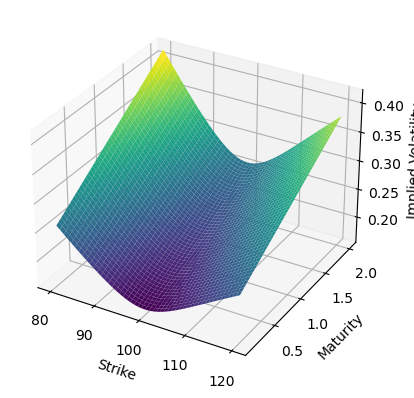

In [262]:
def plot_vol_surface(sigma_0, beta, rho, alpha, F):
    strikes = np.linspace(F-20, F+20, 50)
    maturities = np.linspace(0.1, 2, 50)
    vol_surface = np.zeros((len(strikes), len(maturities)))

    for i, K in enumerate(strikes):
        for j, T in enumerate(maturities):
            vol_surface[i, j] = sabr_vol(sigma_0, beta, rho, alpha, F, K, T)

    K, T = np.meshgrid(strikes, maturities)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(K, T, vol_surface.T, cmap='viridis')
    ax.set_xlabel('Strike')
    ax.set_ylabel('Maturity')
    ax.set_zlabel('Implied Volatility')
    plt.show()

plot_vol_surface(sigma_0_calibrated, beta_calibrated, rho_calibrated, alpha_calibrated, F)